In [1]:
import os
import gc

import numpy as np
from PIL import Image
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import img_as_float
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.utils import conv_utils
from keras.engine.topology import Layer
from keras.datasets import mnist, cifar10
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, PReLU, BatchNormalization, Add, LeakyReLU, Dense, Flatten

Using TensorFlow backend.


In [2]:
path_data = '/home/ubuntu/COMP6208-AutoEncoder/several27/data/'
path_open_images_560_420 = path_data + 'open_images_560_420/'
path_open_images_560_420_train = path_data + 'open_images_560_420_train/'
path_open_images_560_420_val = path_data + 'open_images_560_420_val/'

# Data preprocessing

## Load CIFAR

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape, y_train.shape

169877504/170498071 [============================>.] - ETA: 0s

((50000, 32, 32, 3), (50000, 1))

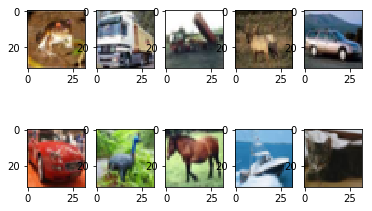

In [4]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    
plt.show()

## Prepare LR CIFAR

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
def images_resize(images, ratio):
    lr_width = images.shape[1] // ratio
    lr_height = images.shape[2] // ratio
    resized = np.zeros((images.shape[0], lr_width, lr_height, images.shape[3]))
    for i in tqdm(range(images.shape[0])):
        resized[i] = resize(images[i], (lr_width, lr_height))
        
    return resized

In [7]:
x_train_lr = images_resize(x_train, 2)
x_test_lr = images_resize(x_test, 2)

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 10000/10000 [00:25<00:00, 399.03it/s]


In [8]:
x_train_lr.shape

(50000, 16, 16, 3)

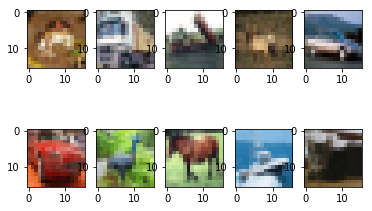

In [9]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_lr[i])
    
plt.show()

## open_images_560_420 generator (or rather 420*560 ugh)

In [ ]:
def generator_images(path, size=(420, 560, 3), ratio=2, batch_size=32):
    lr_height, lr_width = size[0] // ratio, size[1] // ratio
    
    batch_i = 0
    batch = np.zeros((batch_size, size[0], size[1], size[2]))
    batch_scaled = np.zeros((batch_size, lr_height, lr_width, size[2]))
    
    while True:
        for file in os.listdir(path):
            if not file.endswith('.jpg'):
                continue 
            
            if batch_i == batch_size:
                yield batch_scaled, batch
                
                batch_i = 0
                batch = np.zeros((batch_size, size[0], size[1], size[2]))
                batch_scaled = np.zeros((batch_size, lr_height, lr_width, size[2]))
            
            file_path = path + file
            img = img_as_float(Image.open(file_path))
            if len(img.shape) == 2: 
                 img = np.asarray(np.dstack((img, img, img))) 
            
            batch[batch_i] = img
            batch_scaled[batch_i] = resize(img, (lr_height, lr_width))
            
            batch_i += 1

In [ ]:
def count_images(path):
    return sum([1 for file in os.listdir(path) if file.endswith('.jpg')])

In [ ]:
count_images(path_open_images_560_420_train), count_images(path_open_images_560_420_val)

# Network description 

![](srgan_architecture.png)

# Network implementation 

## Generator network

1. Input - Image LR
2. Conv, kernel 3x3, 64 feature maps, what's s1?
3. ParametricReLU
4. B=16 residual blocks
    1. Conv with 3x3 kernel, 64 feature maps and stride 1
    2. Batch Normalization (https://keras.io/layers/normalization/)
    3. ParametricReLU
    4. Conv with 3x3 kernel, 64 feature maps and stride 1
    5. Batch Normalization
    6. Elementwise sum (https://keras.io/layers/merge/ add)
5. Conv with 3x3 kernel, 64 feature maps and stride 1
6. Batch Normalization
7. Elementwise sum (https://keras.io/layers/merge/ add)
8. Shuffle block x2 (? how it's called ?)
    1. Conv with 3x3 kernel, 256 feature maps and stride 1
    2. PixelShuffler x2 https://gist.github.com/t-ae/6e1016cc188104d123676ccef3264981
    3. ParametricReLU
9. Conv with 9x9 kernel, 3 feature maps and stride 1
10. Estimated SR (super-resolved) image

Is the padding `same` a correct one? Otherwise the dims are not the same
Is the number of pixel shufflers the scaling ratio? 

In [11]:
# from https://gist.github.com/t-ae/6e1016cc188104d123676ccef3264981

class PixelShuffler(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(PixelShuffler, self).__init__(**kwargs)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')

    def call(self, inputs):

        input_shape = K.int_shape(inputs)
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))

        if self.data_format == 'channels_first':
            batch_size, c, h, w = input_shape
            if batch_size is None:
                batch_size = -1
            rh, rw = self.size
            oh, ow = h * rh, w * rw
            oc = c // (rh * rw)

            out = K.reshape(inputs, (batch_size, rh, rw, oc, h, w))
            out = K.permute_dimensions(out, (0, 3, 4, 1, 5, 2))
            out = K.reshape(out, (batch_size, oc, oh, ow))
            return out

        elif self.data_format == 'channels_last':
            batch_size, h, w, c = input_shape
            if batch_size is None:
                batch_size = -1
            rh, rw = self.size
            oh, ow = h * rh, w * rw
            oc = c // (rh * rw)

            out = K.reshape(inputs, (batch_size, h, w, rh, rw, oc))
            out = K.permute_dimensions(out, (0, 1, 3, 2, 4, 5))
            out = K.reshape(out, (batch_size, oh, ow, oc))
            return out

    def compute_output_shape(self, input_shape):

        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))

        if self.data_format == 'channels_first':
            height = input_shape[2] * self.size[0] if input_shape[2] is not None else None
            width = input_shape[3] * self.size[1] if input_shape[3] is not None else None
            channels = input_shape[1] // self.size[0] // self.size[1]

            if channels * self.size[0] * self.size[1] != input_shape[1]:
                raise ValueError('channels of input and size are incompatible')

            return (input_shape[0],
                    channels,
                    height,
                    width)

        elif self.data_format == 'channels_last':
            height = input_shape[1] * self.size[0] if input_shape[1] is not None else None
            width = input_shape[2] * self.size[1] if input_shape[2] is not None else None
            channels = input_shape[3] // self.size[0] // self.size[1]

            if channels * self.size[0] * self.size[1] != input_shape[3]:
                raise ValueError('channels of input and size are incompatible')

            return (input_shape[0],
                    height,
                    width,
                    channels)

    def get_config(self):
        config = {'size': self.size,
                  'data_format': self.data_format}
        base_config = super(PixelShuffler, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))

In [12]:
def srgan_generator(input_shape, input_=None):
    kernel_size = (3, 3)
    kernel_size_last = (9, 9)
    features = 64
    features_shuffle = 256
    features_last = 3
    B = 16

    # 1, 2, 3
    input_1 = input_ if input_ is not None else Input(shape=input_shape)
    conv2d_2 = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same')(input_1)
    prelu_3 = PReLU()(conv2d_2)

    # 4 - residual blocks
    last_layer = prelu_3
    for _ in range(B):
        conv2d_4_A = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same')(last_layer)
        bn_4_B = BatchNormalization()(conv2d_4_A)
        prelu_4_C = PReLU()(bn_4_B)
        conv2d_4_D = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same')(prelu_4_C)
        bn_4_E = BatchNormalization()(conv2d_4_D)
        add_4_F = Add()([last_layer, bn_4_E])

        last_layer = add_4_F

    # 5, 6, 7
    conv2d_5 = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same')(last_layer)
    bn_6 = BatchNormalization()(conv2d_5)
    add_7 = Add()([prelu_3, bn_6])

    # 8 - shuffle block
    last_layer = add_7
    for _ in range(1):
        conv2d_8_A = Conv2D(filters=features_shuffle, kernel_size=kernel_size, strides=(1, 1), padding='same')(last_layer)
        shuffler_8_B = PixelShuffler()(conv2d_8_A)
        prelu_8_C = PReLU()(shuffler_8_B)

        last_layer = prelu_8_C

    # 9 
    conv2d_5 = Conv2D(filters=features_last, kernel_size=kernel_size_last, strides=(1, 1), 
                      padding='same')(last_layer)

    return Model(input_1, conv2d_5)

### Train generator

In [54]:
model_generator = srgan_generator((x_train_lr.shape[1], x_train_lr.shape[2], x_train_lr.shape[3]))
# model_generator = srgan_generator((210, 280, 3))
model_generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [55]:
model_generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 16, 16, 3)     0                                            
____________________________________________________________________________________________________
conv2d_133 (Conv2D)              (None, 16, 16, 64)    1792        input_7[0][0]                    
____________________________________________________________________________________________________
p_re_lu_55 (PReLU)               (None, 16, 16, 64)    16384       conv2d_133[0][0]                 
____________________________________________________________________________________________________
conv2d_134 (Conv2D)              (None, 16, 16, 64)    36928       p_re_lu_55[0][0]                 
___________________________________________________________________________________________

In [57]:
train_version = 2

In [58]:
checkpointer = ModelCheckpoint(filepath='data/srgan_generator_weights_%s.{epoch:03d}_{val_acc:.4f}.hdf5' % train_version, 
                               verbose=1, save_best_only=False)
tb_callback = TensorBoard(log_dir='data/tensorboard/', histogram_freq=0, write_graph=True, write_images=True)

In [59]:
model_generator.fit(x_train_lr, x_train, epochs=5, validation_data=(x_test_lr, x_test), callbacks=[tb_callback])

# batch_size = 1
# n_train = 30 # count_images(path_open_images_560_420_train)
# n_val = 3 # count_images(path_open_images_560_420_val)
# with tf.device('/gpu:0'):
#     model_generator.fit_generator(generator_images(path_open_images_560_420_train, batch_size=batch_size), 
#                                   steps_per_epoch=n_train // batch_size,
#                                   validation_data=generator_images(path_open_images_560_420_val, 
#                                                                    batch_size=batch_size),
#                                   validation_steps=n_val // batch_size, epochs=1, callbacks=[tb_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 245s - loss: 450.8564 - acc: 0.7202 - val_loss: 226.9955 - val_acc: 0.7513
Epoch 2/5
50000/50000 [==============================] - 244s - loss: 163.1192 - acc: 0.8198 - val_loss: 160.8087 - val_acc: 0.8470
Epoch 3/5
50000/50000 [==============================] - 244s - loss: 139.3813 - acc: 0.8473 - val_loss: 148.7178 - val_acc: 0.7008
Epoch 4/5
50000/50000 [==============================] - 245s - loss: 128.8283 - acc: 0.8627 - val_loss: 124.6412 - val_acc: 0.8923
Epoch 5/5
50000/50000 [==============================] - 245s - loss: 122.1485 - acc: 0.8708 - val_loss: 120.5207 - val_acc: 0.8956


In [62]:
model_generator.save('data/srgan_generator_%s.model' % train_version)

In [ ]:
model_generator.load_weights('data/srgan_generator_%s.model' % train_version)

In [ ]:
for g, type_ in [(generator_images(path_open_images_560_420_train, batch_size=1), 'train'), 
                 (generator_images(path_open_images_560_420_val, batch_size=batch_size), 'test')]:
    plt.figure(type_, figsize=(15, 30))
    for i, (x_lr, x) in enumerate(g):
        x_lr_ = (x_lr[0] * 255).astype(np.uint8)
        x_ = (x[0] * 255).astype(np.uint8)

        plt.subplot(10, 3, (i * 3) + 1)
        plt.imshow(x_lr_)

        plt.subplot(10, 3, (i * 3) + 2)
        plt.imshow(x_)

        plt.subplot(10, 3, (i * 3) + 3)
        plt.imshow((model_generator.predict(x_lr)[0] * 255).astype(np.uint8))

        if i >= 9:
            break
            
    plt.savefig('data/srgan_generator_%s_%s.png' % (train_version, type_))
    plt.show()

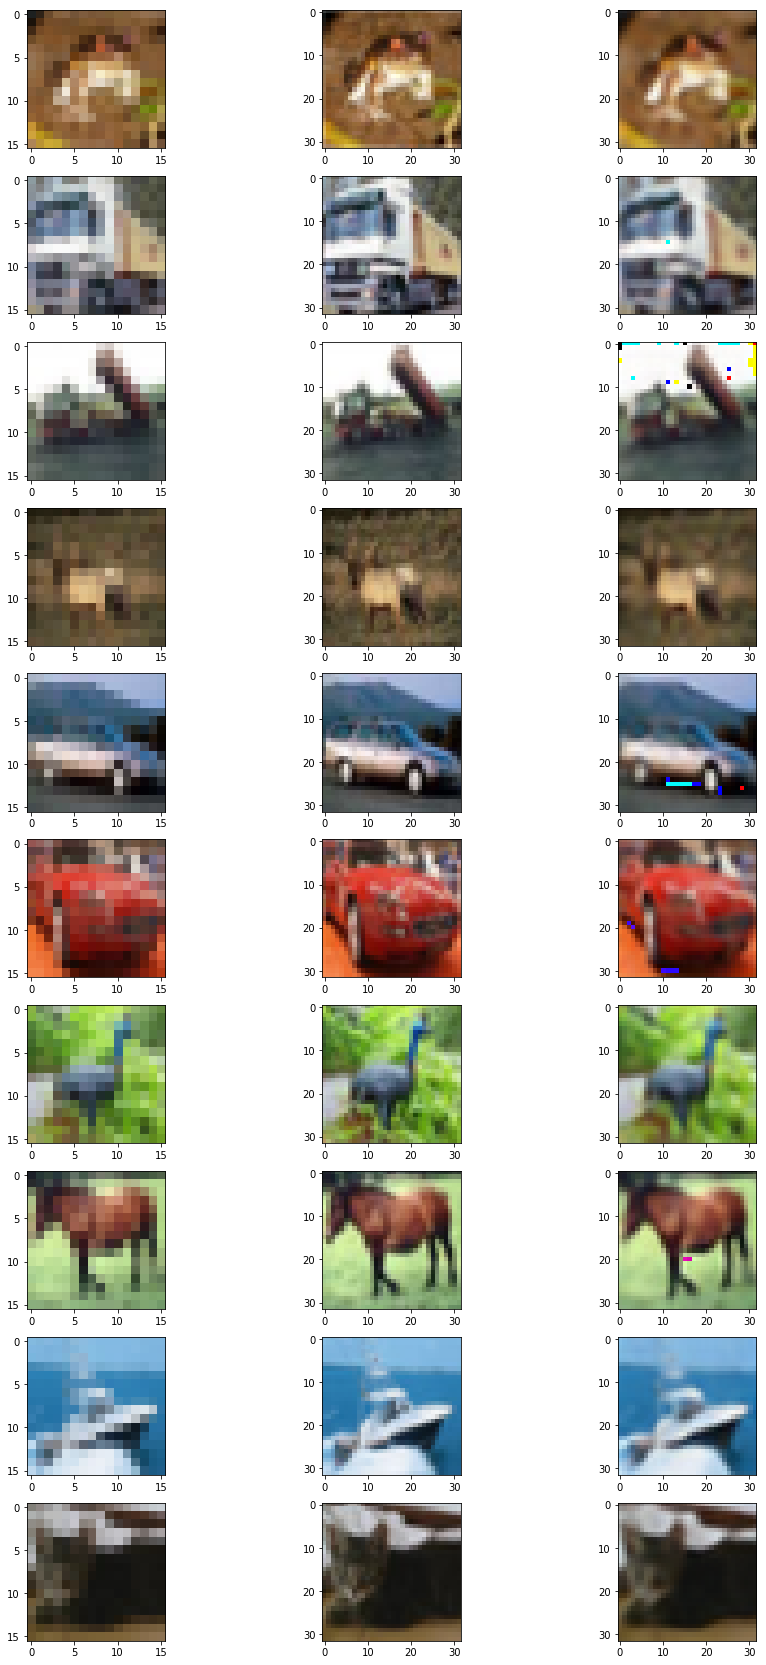

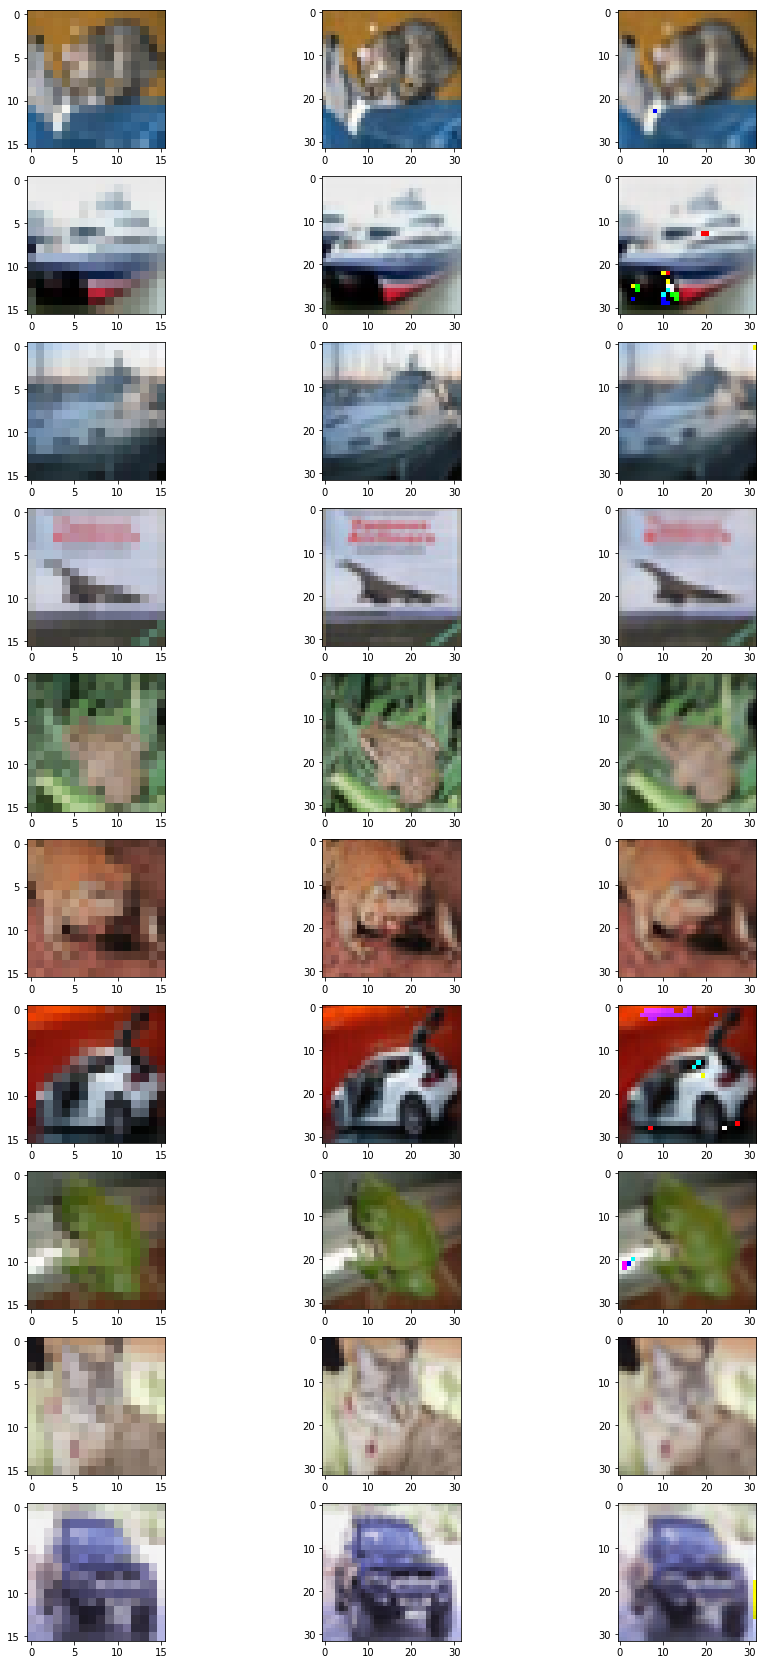

In [61]:
for x, x_lr, type_ in [(x_train, x_train_lr, 'train'), (x_test, x_test_lr, 'test')]:
    plt.figure(figsize=(15, 30))
    for i in range(10):
        plt.subplot(10, 3, (i * 3) + 1)
        plt.imshow(x_lr[i])

        plt.subplot(10, 3, (i * 3) + 2)
        plt.imshow(x[i])

        plt.subplot(10, 3, (i * 3) + 3)
        h, w = x_lr.shape[1], x_lr.shape[2]
        plt.imshow(model_generator.predict(x_lr[i].reshape(1, h, w, 3)).astype(np.uint8)[0])

    plt.savefig('data/srgan_generator_%s_%s.png' % (train_version, type_))
    plt.show()

In [ ]:
plt.figure(figsize=(15, 30))
for i in range(10):
    plt.subplot(10, 3, (i * 3) + 1)
    plt.imshow(x_test_lr[i])

    plt.subplot(10, 3, (i * 3) + 2)
    plt.imshow(x_test[i])

    plt.subplot(10, 3, (i * 3) + 3)
    w, h = x_test_lr.shape[1], x_test_lr.shape[2]
    plt.imshow(model_generator.predict(x_test_lr[i].reshape(1, w, h, 3)).astype(np.uint8)[0])

plt.savefig('data/srgan_generator_%s_test.png' % train_version)
plt.show()

## Discriminator network 

1. Input image
2. Conv2d with 3x3 kernel, 64 filters, and 1 stride
3. Leaky ReLU (https://keras.io/layers/advanced-activations/#leakyrelu)
3. Conv2d block
    1. Conv2d with 3x3 kernel, 64 filters, and 1 stride
    2. Batch normalization
    3. Leaky ReLU (https://keras.io/layers/advanced-activations/#leakyrelu)
4. Repeat 4 with 128 filters x 2 
5. Repeat 4 with 256 filters x 2 
6. Repeat 4 with 512 filters x 2 
7. Dense layer with 1024
8. Leaky ReLU
9. Dense 1 binary
10. Sigmoid

In [13]:
def srgan_discriminator():
    input_shape = 32, 32, 3
    features_1 = 64
    features_2, features_3, features_4 = 128, 256, 512
    kernel_size = 3, 3
    strides = 1, 1
    strides_2 = 2, 2
    
    input_1 = Input(shape=input_shape)
    conv2d_2 = Conv2D(filters=features_1, kernel_size=kernel_size, strides=strides, padding='same')(input_1)
    lrelu_3 = LeakyReLU()(conv2d_2)
    
    conv2d_4_A = Conv2D(filters=features_1, kernel_size=kernel_size, strides=strides_2, padding='same')(lrelu_3)
    conv2d_4_B = BatchNormalization()(conv2d_4_A)
    lrelu_4_c = LeakyReLU()(conv2d_4_B)
    
    last_layer = lrelu_4_c
    for _features in [features_2, features_3, features_4]:
        for i in range(2):
            conv2d_5_A = Conv2D(filters=_features, kernel_size=kernel_size, strides=(strides if i == 0 else strides_2), 
                                padding='same')(last_layer)
            conv2d_5_B = BatchNormalization()(conv2d_5_A)
            lrelu_5_C = LeakyReLU()(conv2d_5_B)
            
            last_layer = lrelu_5_C
    
    flatten_8 = Flatten()(last_layer)
    dense_8 = Dense(1024)(flatten_8)
    lrelu_9 = LeakyReLU()(dense_8)
    dense_10 = Dense(1, activation='sigmoid')(lrelu_9)
    
    return Model(input_1, dense_10)

### Train discriminator

In [14]:
def discriminator_generator_cifar(model_generator, x, x_predictions, batch_size=64):        
    batch_size = batch_size // 2
    
    batch_i = 0
    batch = np.zeros((batch_size, 32, 32, 3))
    batch_predictions = np.zeros((batch_size, 32, 32, 3))
    
    while True:
        for i in range(x.shape[0]):
            if batch_i == batch_size:
                
                # TODO: use soft and noisy labels
                yield np.concatenate((batch, batch_predictions)), \
                    np.concatenate((np.ones(batch_size), np.zeros(batch_size)))
                
                batch_i = 0
                batch = np.zeros((batch_size, 32, 32, 3))
                batch_predictions = np.zeros((batch_size, 32, 32, 3))
            
            batch[batch_i] = x[i]
            batch_predictions[batch_i] = x_predictions[i]
            
            batch_i += 1

In [95]:
epochs = 5
batch_size = 64
train_version = 2

In [96]:
# generator_in = Input(shape=(16, 16, 3))

model_generator = srgan_generator((16, 16, 3)) #, input_=generator_in)
model_discriminator = srgan_discriminator()

# generator_out = model_generator(generator_in)

# discriminator_out = model_discriminator(generator_out)
# model_srgan = Model(generator_in, discriminator_out)

In [97]:
model_generator.compile(optimizer='adam', loss='mse')
model_discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# TODO try using softmax instead of sigmoid for categorical crossentropy
# model_srgan.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [98]:
model_discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_337 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_338 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_307 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_339 (Conv2D)          (None, 16, 16, 128)       73856     
__________

In [66]:
model_generator.load_weights('data/srgan_generator_2.model')

In [99]:
path_train_predictions = path_data + ('srgan_generator_%s_train_predictions.npy' % train_version)
path_test_predictions = path_data + ('srgan_generator_%s_test_predictions.npy' % train_version)

In [68]:
x_train_predictions = model_generator.predict(x_train_lr).astype(np.uint8)
x_test_predictions = model_generator.predict(x_test_lr).astype(np.uint8)

In [76]:
# TEMPORARY FIX OF GPU MEMORY LEAK ? 

np.save(path_train_predictions, x_train_predictions)
np.save(path_test_predictions, x_test_predictions)

In [84]:
x_train_predictions = np.load(path_train_predictions)
x_test_predictions = np.load(path_test_predictions)

In [100]:
checkpointer = ModelCheckpoint(filepath='data/srgan_discriminator_weights_%s.{epoch:03d}_{val_acc:.4f}.hdf5' % 
                               train_version, verbose=1, save_best_only=False)
tb_callback = TensorBoard(log_dir='data/tensorboard/', histogram_freq=0, write_graph=True, write_images=True)

In [101]:
# model_generator.fit(x_train_lr, x_train, epochs=100, validation_data=(x_test_lr, x_test), callbacks=[tb_callback])

with tf.device('/gpu:0'):
    model_discriminator.fit_generator(discriminator_generator_cifar(model_generator, x_train, x_train_predictions, 
                                                                    batch_size), 
                                      steps_per_epoch=x_train.shape[0] // (batch_size * 2), 
                                      validation_data=discriminator_generator_cifar(model_generator, 
                                                                                    x_test, x_test_predictions, 
                                                                                    batch_size), 
                                      validation_steps=x_test.shape[0] // (batch_size * 2), epochs=epochs, 
                                      callbacks=[tb_callback, checkpointer])

Epoch 1/5
390/390 [==============================] - 34s - loss: 0.6870 - acc: 0.5973 - val_loss: 0.5329 - val_acc: 0.8011
Epoch 2/5
390/390 [==============================] - 32s - loss: 0.1053 - acc: 0.9614 - val_loss: 1.3938 - val_acc: 0.7448
Epoch 3/5
390/390 [==============================] - 32s - loss: 0.0362 - acc: 0.9875 - val_loss: 0.0163 - val_acc: 0.9936
Epoch 4/5
390/390 [==============================] - 32s - loss: 0.0221 - acc: 0.9927 - val_loss: 0.1254 - val_acc: 0.9475
Epoch 5/5
390/390 [==============================] - 32s - loss: 0.0213 - acc: 0.9925 - val_loss: 0.6040 - val_acc: 0.8438


In [102]:
model_discriminator.save('data/srgan_discriminator_%s.model' % train_version)

In [87]:
to_categorical(np.concatenate((np.ones(batch_size), np.zeros(batch_size))))

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

## Train full SRGAN

In [115]:
generator_in = Input(shape=(16, 16, 3))

model_generator = srgan_generator((16, 16, 3), input_=generator_in)
model_discriminator = srgan_discriminator()

generator_out = model_generator(generator_in)

discriminator_out = model_discriminator(generator_out)
model_srgan = Model(generator_in, discriminator_out)

In [116]:
model_srgan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [117]:
model_srgan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 16, 16, 3)         0         
_________________________________________________________________
model_22 (Model)             (None, 32, 32, 3)         1736195   
_________________________________________________________________
model_23 (Model)             (None, 1)                 6792001   
Total params: 8,528,196
Trainable params: 8,520,260
Non-trainable params: 7,936
_________________________________________________________________


In [118]:
batch_size = 64
train_version = 2

In [119]:
model_generator.load_weights(path_data + ('srgan_generator_%s.model' % train_version))
model_discriminator.load_weights(path_data + ('srgan_discriminator_%s.model' % train_version))

In [120]:
checkpointer = ModelCheckpoint(filepath='data/srgan_weights_%s.{epoch:03d}_{val_acc:.4f}.hdf5' % 
                               train_version, verbose=1, save_best_only=False)
tb_callback = TensorBoard(log_dir='data/tensorboard/', histogram_freq=0, write_graph=True, write_images=True)

In [121]:
# model_generator.fit(x_train_lr, x_train, epochs=100, validation_data=(x_test_lr, x_test), callbacks=[tb_callback])

# discriminative network should be online trained while training whole GAN as well, so that 
# it improves on differating the original vs superscaled

with tf.device('/gpu:0'):
    for _ in range(5):
        for batch_i in tqdm(np.arange(0, x_train_lr.shape[0], batch_size)):
            if batch_size + batch_i > x_train_lr.shape[0]:
                continue

            x_train_batch = x_train[batch_i:batch_i+batch_size]
            x_train_lr_batch = x_train_lr[batch_i:batch_i+batch_size]

            for layer in model_generator.layers:
                layer.trainable = True
            for layer in model_discriminator.layers:
                layer.trainable = False

            model_srgan.train_on_batch(x_train_lr_batch, [1] * batch_size)

            for layer in model_generator.layers:
                layer.trainable = False
            for layer in model_discriminator.layers:
                layer.trainable = True

            x_train_predictions = model_generator.predict(x_train_lr_batch).astype(np.uint8)
            model_discriminator.train_on_batch(x_train_predictions, [0] * batch_size)
            model_discriminator.train_on_batch(x_train_batch, [1] * batch_size)
            
        print(model_srgan.evaluate(x_test_lr, [1] * x_test_lr.shape[0]))

100%|██████████| 782/782 [07:53<00:00,  1.65it/s]


 9984/10000 [============================>.] - ETA: 0s

  0%|          | 0/782 [00:00<?, ?it/s]

[0.11304909777641296, 0.99709999999999999]


100%|██████████| 782/782 [07:32<00:00,  1.73it/s]

   96/10000 [..............................] - ETA: 19s

 9984/10000 [============================>.] - ETA: 0s

  0%|          | 0/782 [00:00<?, ?it/s]

[0.1598829166650772, 0.98409999999999997]


 11%|█         | 85/782 [00:49<06:43,  1.73it/s]

KeyboardInterrupt: 

In [83]:
print(model_srgan.evaluate(x_test_lr, [1] * x_test_lr.shape[0]))

 9984/10000 [============================>.] - ETA: 0s[0.044065057545900344, 0.98860000000000003]


In [81]:
model_srgan.save(path_data + ('srgan_%s.model' % train_version))
model_srgan.save(path_data + ('srgan_final_generator_%s.model' % train_version))

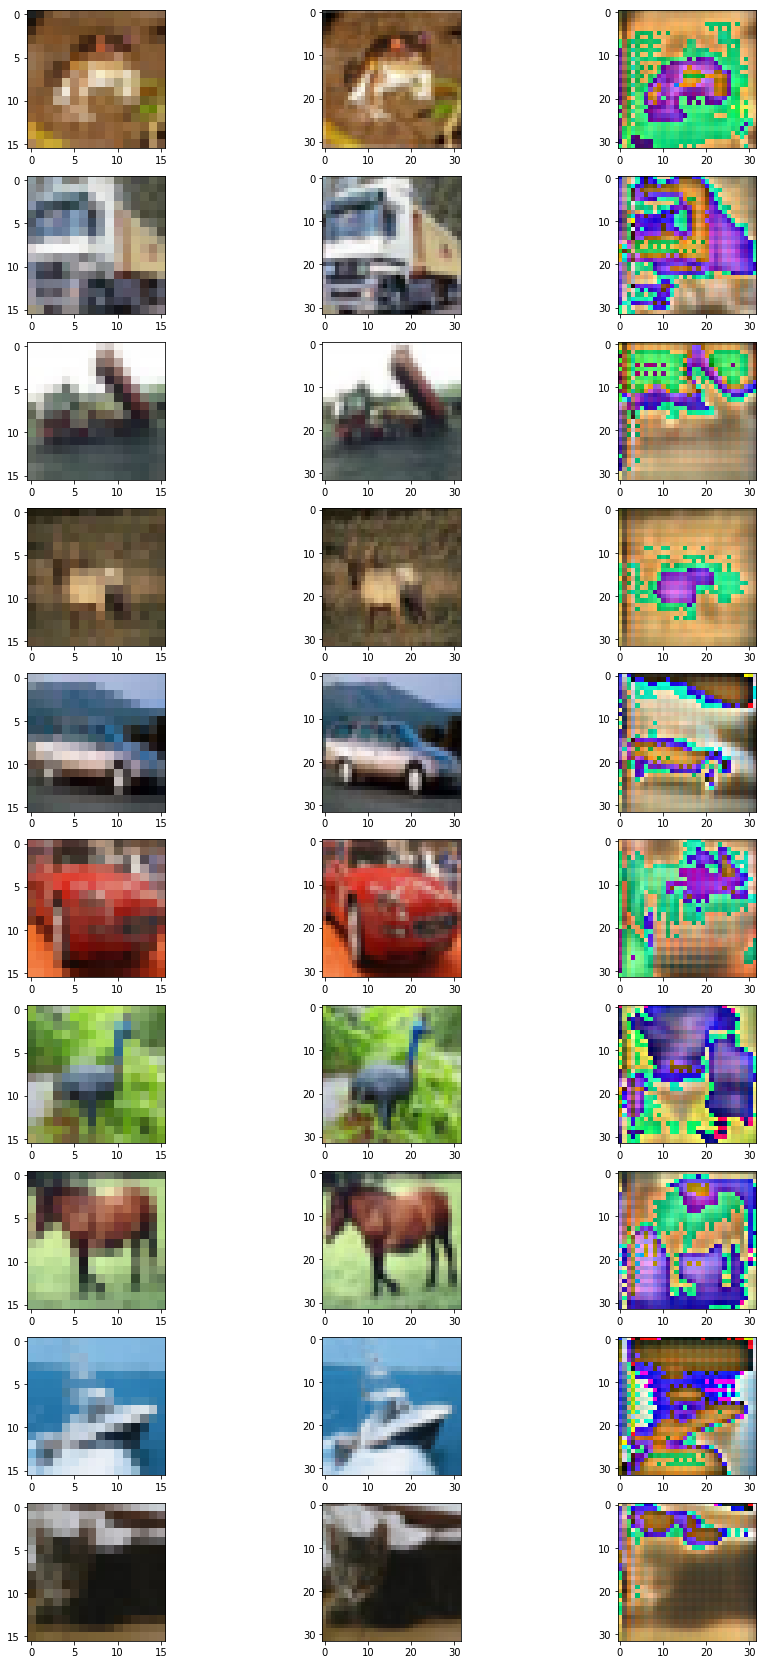

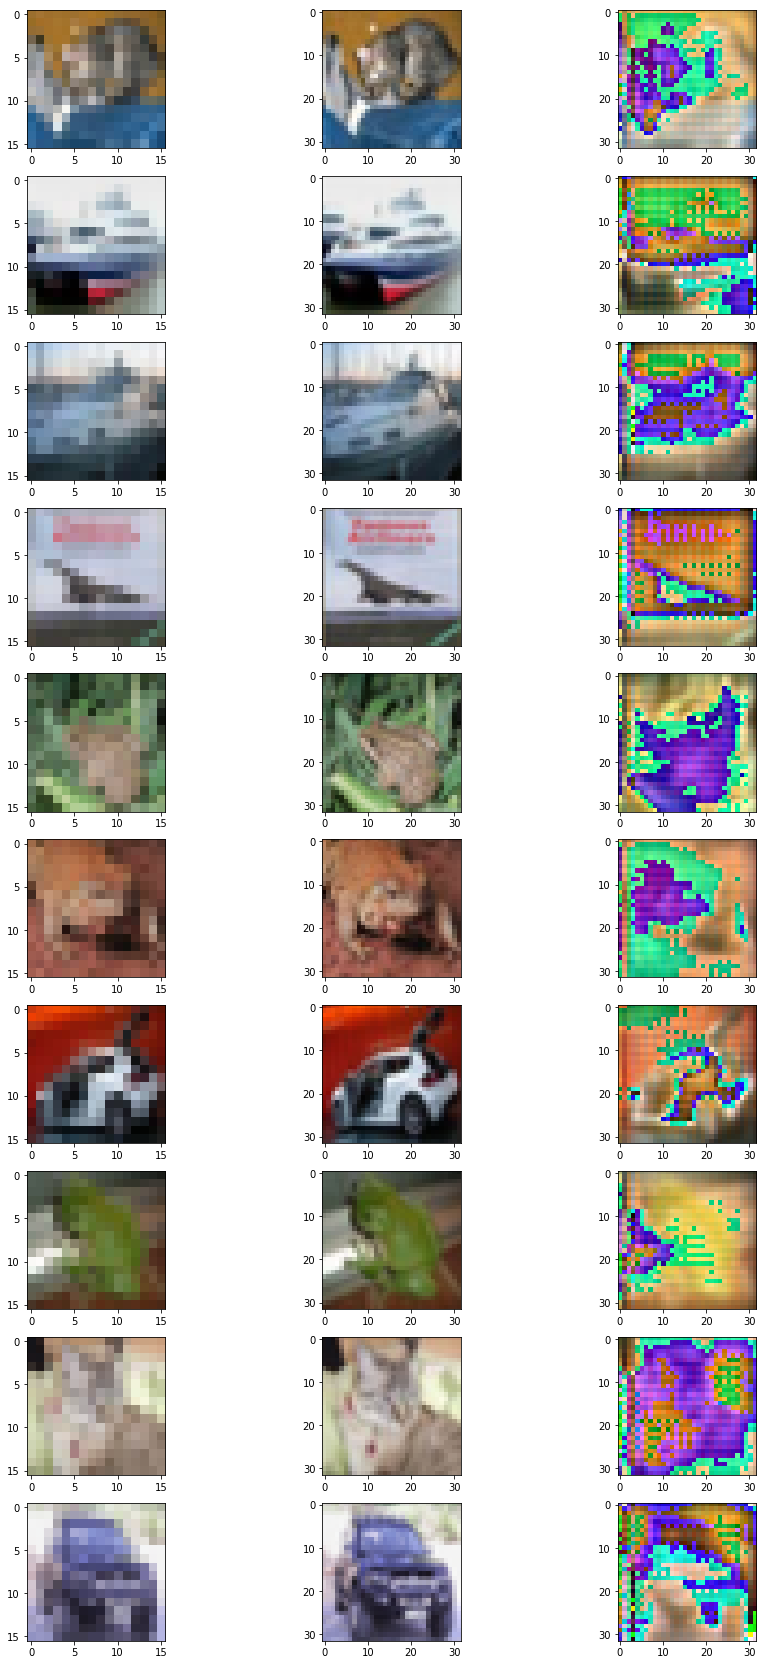

In [122]:
for x, x_lr, type_ in [(x_train, x_train_lr, 'train'), (x_test, x_test_lr, 'test')]:
    plt.figure(figsize=(15, 30))
    for i in range(10):
        plt.subplot(10, 3, (i * 3) + 1)
        plt.imshow(x_lr[i])

        plt.subplot(10, 3, (i * 3) + 2)
        plt.imshow(x[i])

        plt.subplot(10, 3, (i * 3) + 3)
        h, w = x_lr.shape[1], x_lr.shape[2]
        plt.imshow(model_generator.predict(x_lr[i].reshape(1, h, w, 3)).astype(np.uint8)[0])

    plt.savefig('data/srgan_generator_%s_%s.png' % (train_version, type_))
    plt.show()

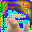

In [123]:
Image.fromarray(model_generator.predict(x_lr[i].reshape(1, h, w, 3)).astype(np.uint8)[0])

In [124]:
model_discriminator.predict(model_generator.predict(x_lr[0].reshape(1, h, w, 3)).astype(np.uint8))

array([[ 0.74691802]], dtype=float32)

In [94]:
x_lr[i].reshape(1, h, w, 3)

array([[[[ 0.5127451 ,  0.50588235,  0.47843137],
         [ 0.56568627,  0.53823529,  0.52647059],
         [ 0.60980392,  0.60784314,  0.61078431],
         [ 0.70196078,  0.70490196,  0.70784314],
         [ 0.61176471,  0.59117647,  0.58627451],
         [ 0.41960784,  0.37156863,  0.36078431],
         [ 0.35196078,  0.30980392,  0.29313725],
         [ 0.3372549 ,  0.28235294,  0.25196078],
         [ 0.41372549,  0.35098039,  0.3127451 ],
         [ 0.48431373,  0.41960784,  0.39411765],
         [ 0.55196078,  0.50294118,  0.49313725],
         [ 0.6254902 ,  0.6       ,  0.58823529],
         [ 0.69901961,  0.69019608,  0.70588235],
         [ 0.74313725,  0.75196078,  0.76470588],
         [ 0.7754902 ,  0.79607843,  0.8127451 ],
         [ 0.78823529,  0.8127451 ,  0.83333333]],

        [[ 0.68333333,  0.69705882,  0.69411765],
         [ 0.64607843,  0.64901961,  0.64313725],
         [ 0.73431373,  0.73431373,  0.73235294],
         [ 0.73823529,  0.74019608,  0.74019608]

In [93]:
model_generator.predict(x_lr[i].reshape(1, h, w, 3).astype(np.uint8)).astype(np.uint8)[0]

array([[[219, 247, 231],
        [195, 212, 202],
        [188, 232, 207],
        ..., 
        [167, 205, 189],
        [187, 239, 216],
        [200, 230, 219]],

       [[204, 236, 220],
        [179, 200, 194],
        [173, 222, 199],
        ..., 
        [136, 178, 167],
        [163, 219, 198],
        [181, 213, 203]],

       [[198, 233, 216],
        [178, 200, 192],
        [165, 214, 189],
        ..., 
        [135, 176, 153],
        [161, 216, 185],
        [182, 214, 192]],

       ..., 
       [[ 56, 121, 164],
        [158,  28,  43],
        [248,  65, 130],
        ..., 
        [ 64,  74, 129],
        [210, 190, 246],
        [152, 149, 181]],

       [[118, 184, 183],
        [234,  97,  57],
        [110, 183, 169],
        ..., 
        [209, 200, 182],
        [ 74,  51,  45],
        [226, 212, 208]],

       [[134, 198, 189],
        [  0, 110,  63],
        [115, 189, 156],
        ..., 
        [247, 234, 194],
        [116,  93,  66],
        [  9, 247,

In [87]:
model_generator.predict(x_lr[0].reshape(1, h, w, 3))

array([[[[ 112.52165222,  113.29457855,    7.07539511],
         [  92.96488953,   55.69684982,  -39.48129272],
         [ 119.70095062,  125.21121979,   -7.63048267],
         ..., 
         [  41.45542908,   17.46833229,  -76.71392059],
         [  65.10507965,   66.55814362,  -21.13381004],
         [  41.01665497,   21.65631485,  -30.77451897]],

        [[ 121.56832123,  122.78394318,   -2.65687418],
         [  99.53627777,   50.42704773,  -60.67370224],
         [ 128.69444275,  133.56219482,  -20.52041626],
         ..., 
         [  26.04014778,   -2.84948492, -109.46891785],
         [  64.33377075,   66.25634766,  -34.26319504],
         [  39.65294647,   14.3155365 ,  -43.74713135]],

        [[ 129.18240356,  137.74472046,  -20.16658592],
         [ 101.14211273,   59.02780914,  -88.93902588],
         [ 126.2184906 ,  142.49765015,  -53.56936646],
         ..., 
         [  26.86322021,    6.14418173, -140.30430603],
         [  73.02295685,   81.02567291,  -57.93928146],

In [86]:
model_generator.predict(x_lr[0].reshape(1, h, w, 3)).astype(np.uint8)

array([[[[112, 113,   7],
         [ 92,  55, 217],
         [119, 125, 249],
         ..., 
         [ 41,  17, 180],
         [ 65,  66, 235],
         [ 41,  21, 226]],

        [[121, 122, 254],
         [ 99,  50, 196],
         [128, 133, 236],
         ..., 
         [ 26, 254, 147],
         [ 64,  66, 222],
         [ 39,  14, 213]],

        [[129, 137, 236],
         [101,  59, 168],
         [126, 142, 203],
         ..., 
         [ 26,   6, 116],
         [ 73,  81, 199],
         [ 47,  28, 194]],

        ..., 
        [[  5, 138, 146],
         [  8, 155, 178],
         [243, 182, 185],
         ..., 
         [ 55, 195, 210],
         [ 32, 155, 173],
         [ 26, 130, 145]],

        [[ 70, 183, 175],
         [ 99, 228, 220],
         [105,  16, 247],
         ..., 
         [210,  66,  40],
         [150, 253, 239],
         [107, 193, 187]],

        [[111, 208, 197],
         [161,  15, 255],
         [178,  61,  33],
         ..., 
         [ 53, 142, 104],
  